# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
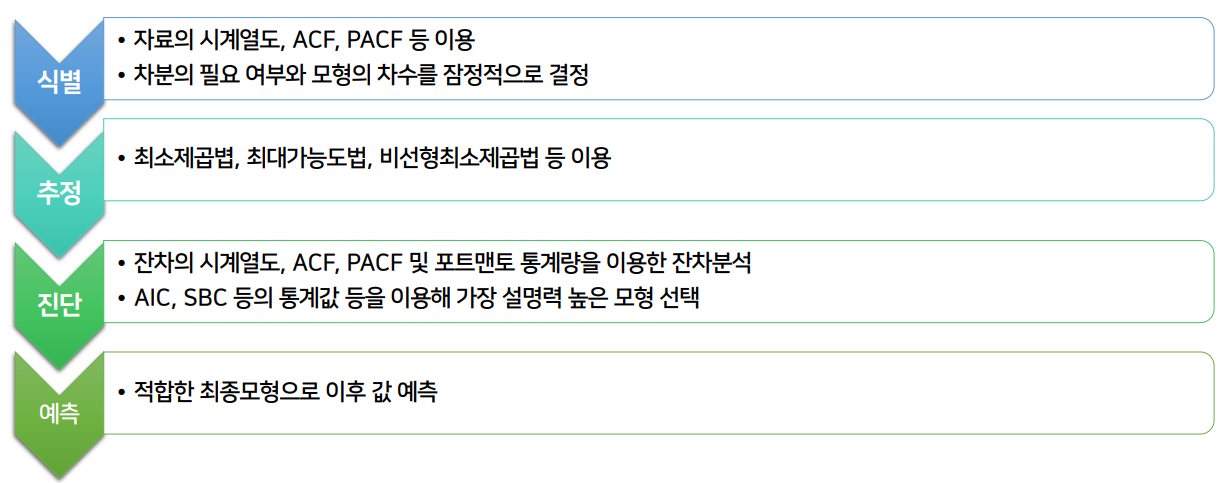

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

# 코드

## 라이브러리 불러오기

In [65]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import datetime
from statsmodels.tsa.arima_model import ARIMAResults

## 데이터 불러오기

In [66]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


---

## [1] Box-Jenkins 방법론

### 1. 식별

#### 1-1. 시각화

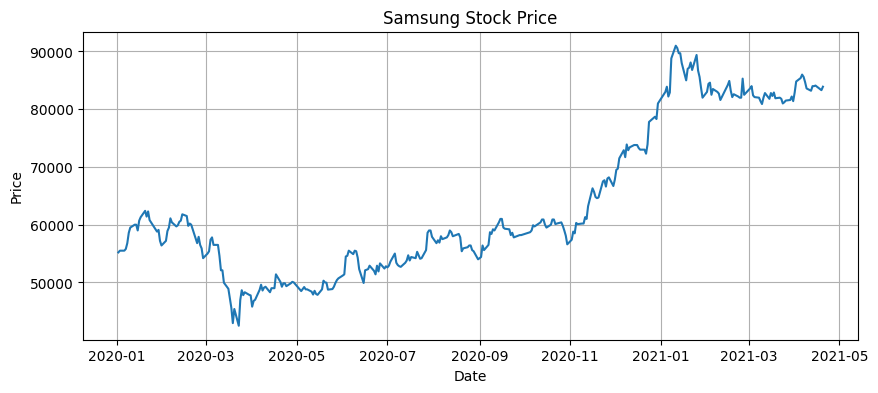

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(samsung_df['price'])
plt.title('Samsung Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

- 단순 시각화를 통해, 정상성을 띄는 데이터는 아님을 확인할 수 있고 이후 ACF와 PACF 지표도 함께 활용 예정
- 차분을 진행할 필요가 보임

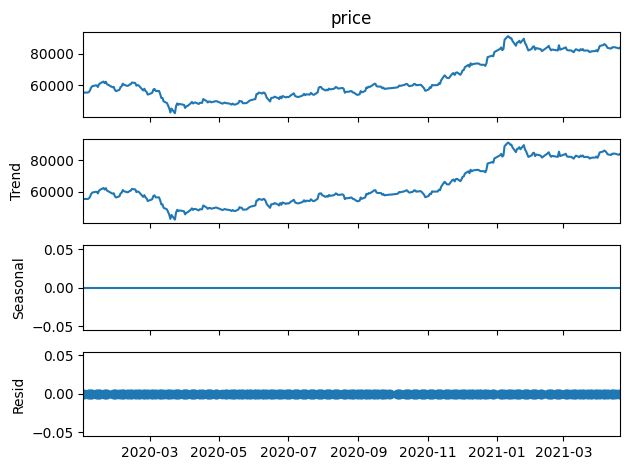

In [70]:
# 주기 정보 확인하기 -> 특별한 이슈 X
# 주기 정보를 추가하여 seasonal_decompose 함수 사용
a = seasonal_decompose(samsung_df['price'], model="add", period=1)
a.plot();

1. 원본 데이터(시계열): 가장 위에 있는 그래프는 분해되기 전의 원본 시계열 데이터를 나타냅니다. 이는 주식 가격 데이터의 변동을 보여줍니다.
2. 트렌드(Trend) 성분: 두 번째 그래프는 시계열 데이터에서 추세(Trend)를 추정한 것입니다. 추세는 시계열 데이터의 장기적인 변화를 나타냅니다. 주식 가격 데이터에서 추세를 통해 가격의 증가 또는 감소 경향을 확인할 수 있습니다.
   - 트렌드가 원본 데이터셋과 유사하게 나타나므로 특별한 추세나 패턴이 없음을 확인
3. 계절성(Seasonal) 성분: 세 번째 그래프는 계절성(Seasonal) 성분을 나타냅니다. 계절성은 일정한 주기로 반복되는 패턴을 의미하며, 시계열 데이터 내에서 주기적인 변동을 표현합니다. 주식 가격 데이터에서는 특정한 기간에 주식 가격이 반복되는 패턴을 확인할 수 있습니다.
    - 계절성 또한 주기적인 패턴 X
4. 잔차(Residual) 성분: 마지막 그래프는 추세와 계절성을 제거한 후의 잔차(Residual) 성분을 보여줍니다. 잔차는 추세와 계절성을 제외한 나머지 변동을 의미하며, 모델의 예측 오차에 해당합니다. 이 그래프에서는 잔차가 어떤 패턴을 가지는지 확인할 수 있습니다.
    - 잔차 또한 주기적인 패턴 X

#### 1-2. 차분 결정
- 차분(Differencing)이 필요한지
- ARIMA 모형의 p, d, q 차수

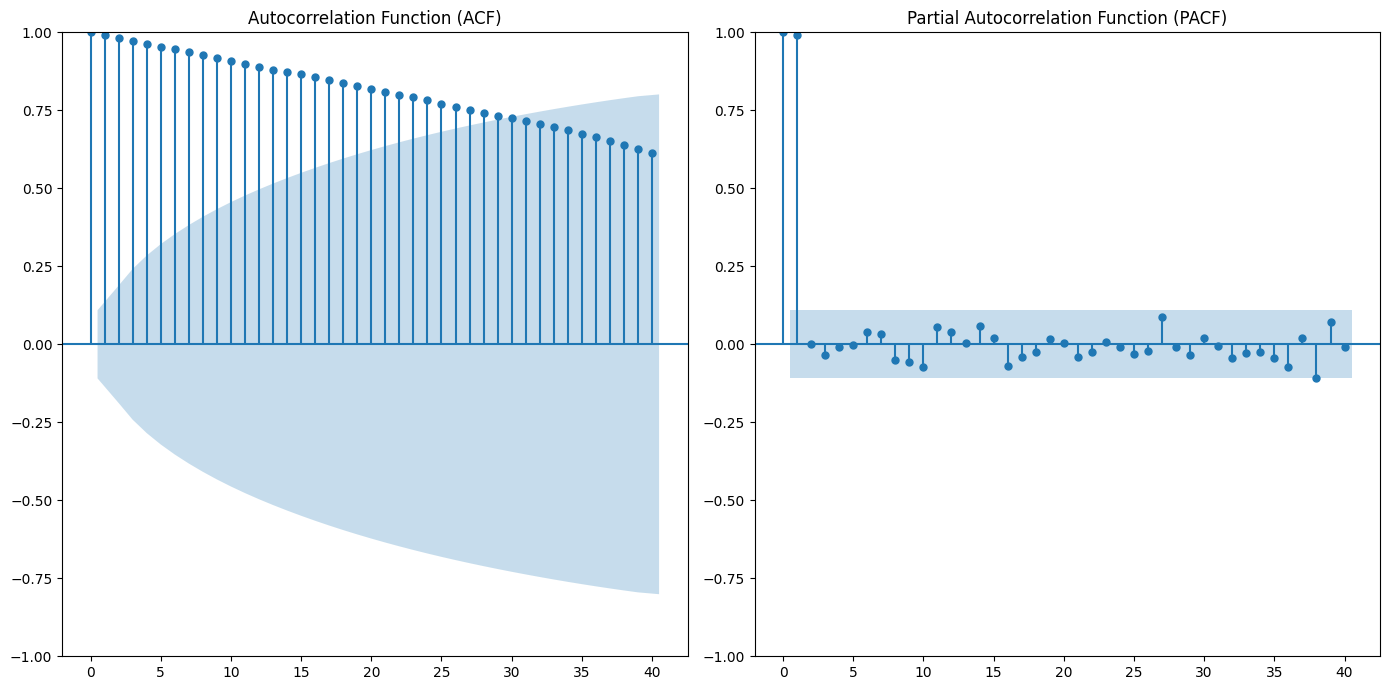

In [23]:
# ACF와 PACF 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(10, ))

# ACF
plot_acf(samsung_df['price'], lags=40, ax=ax[0])
ax[0].set_title('차분 전 ACF')

# PACF
plot_pacf(samsung_df['price'], lags=40, ax=ax[1])
ax[1].set_title('차분 전 PACF')

plt.tight_layout()
plt.show()

#### 1-3. ACF&PACF 종합 결론
    - ACF 그래프에서는 지수적으로 감소하는 패턴이 있습니다. 이는 원 데이터가 비정상성을 나타내는 것일 수 있습니다.
    - PACF 그래프에서는 몇몇 지점에서 눈에 띄는 특징이 있지만, 명확한 패턴은 없어 보입니다.

#### 1-4. 1차 차분을 적용한 후 다시 ACF와 PACF

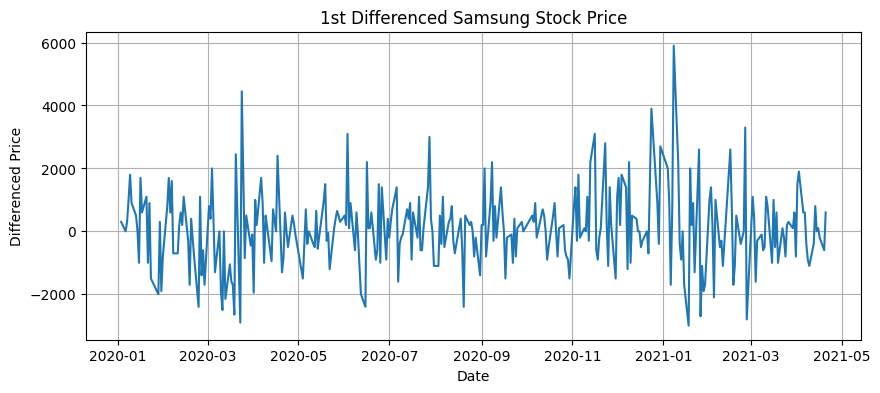

In [26]:
# 1차 차분
df_diff = samsung_df['price'].diff().dropna()

# 차분 후의 시계열 그래프 그리기
plt.figure(figsize=(10, 4))
plt.plot(df_diff)
plt.title('1차 차분 후 Samsung Stock Price')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.grid(True)
plt.show()

- 정상적으로 차분이 진행된 것이 확인 가능

/tmp/ipykernel_24355/2818530612.py:12: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24355/2818530612.py:12: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24355/2818530612.py:12: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from current font.
  plt.tight_layout()
/home/dhj9842/Downloads/week6-20230828T143351Z-001/week6/Time Series Analysis/myenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhj9842/Downloads/week6-20230828T143351Z-001/week6/Time Series Analysis/myenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhj9842/Downloads/week6-20230828T143351Z-001/week6/Time

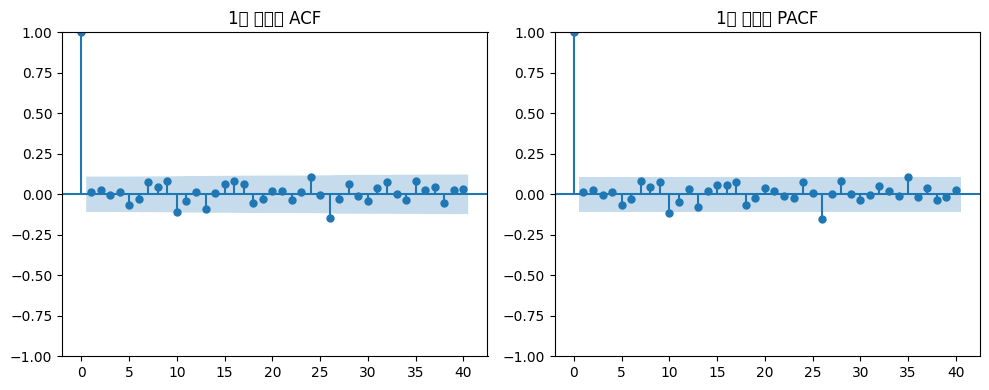

In [28]:
# 차분 후의 ACF와 PACF 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(df_diff, lags=40, ax=ax[0])
ax[0].set_title('1차 차분후 ACF')

# PACF
plot_pacf(df_diff, lags=40, ax=ax[1])
ax[1].set_title('1차 차분후 PACF')

plt.tight_layout()
plt.show()

1. ACF 그래프에서는 지수적 감소나 계절성 패턴이 없어 보입니다. 이는 차분 후에 시계열 데이터가 정상성을 가질 가능성이 높다는 것을 의미합니다.
2. PACF 그래프에서는 몇몇 지점에서 눈에 띄는 특징이 있지만, 대체로 빠르게 0으로 수렴합니다.
3. 이 정보를 토대로, 차분 d=1과 모형의 p와 q의 차수를 선택할 수 있습니다.
    - PACF가 처음으로 0을 통과하는 lag를 p로 선택
    - ACF가 처음으로 0을 통과하는 lag를 q로 선택
4. 이를 바탕으로 ARIMA 모델의 차수를 결정할 수 있습니다.
    - p =1 or p=2
    - d=1
    - q=1
5. 두 지표 모두 지수적 감소나 계절성 패턴을 보이지 않고 정상성 여부를 만족했으니,<br>(최소제곱법, 최대가능도법, 비선형 제곱법, ARIMA)를 이용하여 추정하고 진단하도록 하겠습니다.

---

### 2. 추정
- 최소제곱법 & 비선형 최소제곱법 (Non-linear Least Squares)의 경우, 주로 원본 데이터를 사용하며 계절시 계절성 차분 진행
- 최대 가능도 추정(MLE)는 정상성을 만족하는 시계열 데이터에 적용하고 만족하지 않을시 차분 진행
- ARIMA의 경우 기본적으로 MLE를 사용합니다.

In [43]:
df_diff = pd.DataFrame(samsung_df['price'].diff().dropna())
df_diff.columns = ['price']
df_diff.head()

,price
day,
2020-01-03,300.0
2020-01-06,0.0
2020-01-07,300.0
2020-01-08,1000.0
2020-01-09,1800.0


### 2&3. 추정 및 진단
- 참고:https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [63]:
from statsmodels.tsa.arima.model import ARIMA

# p=1, d=1, q=1인 ARIMA 모델 적합
# df_diff를 사용하지 않고, d=1로 설정하여 자동적으로 차분 진행
model_111 = ARIMA(samsung_df['price'], order=(1, 1, 1))
result_111 = model_111.fit()

# AIC 출력
aic_111 = result_111.aic
aic_111

/home/dhj9842/Downloads/week6-20230828T143351Z-001/week6/Time Series Analysis/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dhj9842/Downloads/week6-20230828T143351Z-001/week6/Time Series Analysis/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dhj9842/Downloads/week6-20230828T143351Z-001/week6/Time Series Analysis/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


5479.973438767432

In [61]:
result_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                  322
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2736.987
Date:                Tue, 29 Aug 2023   AIC                           5479.973
Time:                        02:48:06   BIC                           5491.288
Sample:                             0   HQIC                          5484.491
                                - 322                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8885      0.189      4.698      0.000       0.518       1.259
ma.L1         -0.8717      0.208     -4.191      0.000      -1.279      -0.464
sigma2      1.491e+06   8.42e+04     17.718      0.000    1.33e+06    1.66e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                63.33
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.57
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA(1, 1, 1) 모델 요약 분석

#### 기본 정보

- **종속 변수(Dep. Variable)**: 'price'
- **관측치 수(No. Observations)**: 322
- **모델(Model)**: ARIMA(1, 1, 1)

#### 모델 적합도

- **로그 우도(Log Likelihood)**: -2736.987
- **AIC (Akaike Information Criterion)**: 5479.973
- **BIC (Bayesian Information Criterion)**: 5491.288

#### 계수(Coefficients)

- **ar.L1**: 0.8885 (p-값: 0.000)
- **ma.L1**: -0.8717 (p-값: 0.000)
- **sigma2**: \(1.491 \times 10^6\) (p-값: 0.000)

#### 통계적 검정

- **Ljung-Box Test**: 잔차의 자기상관이 거의 없음 (Prob(Q): 0.91)
- **Jarque-Bera Test**: 잔차가 정규분포를 따르지 않음 (Prob(JB): 0.00)
- **Heteroskedasticity Test**: 잔차의 분산이 일정하지 않음 (Prob(H): 0.09)

#### 해석

1. 이 모델의 AIC와 BIC는 (2,1,1) 모델보다 낮아져 있으므로 상대적으로 더 나은 적합도를 보이고 있습니다.
2. AR과 MA의 계수가 통계적으로 매우 유의미합니다 (p-값이 0.000).
3. 잔차의 분포가 여전히 정규분포를 따르지 않고, 분산이 일정하지 않습니다.

#### 총평
이 모델은 (2,1,1)모델보다 더 나은 성능을 보이고 있습니다. 계수가 통계적으로 유의미하며, AIC와 BIC도 더 낮습니다.<br>
하지만 잔차의 정규성과 분산의 일정성에 대한 문제는 여전히 있습니다.<br>
이를 고려하여 모델을 더 개선할 필요가 있을 수 있습니다.

In [50]:
# p=2, d=1, q=1인 ARIMA 모델 적합
# df_diff를 사용하지 않고, d=1로 설정하여 자동적으로 차분 진행
model_211 = ARIMA(samsung_df['price'], order=(2, 1, 1))
result_211 = model_211.fit()

# AIC 출력
aic_211 = result_211.aic
aic_211

/home/dhj9842/Downloads/week6-20230828T143351Z-001/week6/Time Series Analysis/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dhj9842/Downloads/week6-20230828T143351Z-001/week6/Time Series Analysis/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dhj9842/Downloads/week6-20230828T143351Z-001/week6/Time Series Analysis/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


5483.281830501392

In [60]:
result_211.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                  322
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2737.641
Date:                Tue, 29 Aug 2023   AIC                           5483.282
Time:                        02:47:55   BIC                           5498.368
Sample:                             0   HQIC                          5489.305
                                - 322                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0244      5.259      0.005      0.996     -10.284      10.332
ar.L2          0.0094      0.077      0.121      0.903      -0.142       0.161
ma.L1         -0.0129      5.269     -0.002      0.998     -10.341      10.315
sigma2      1.511e+06   8.53e+04     17.717      0.000    1.34e+06    1.68e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                62.49
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.55
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA(2,1,1) 모델 요약 분석

#### 기본 정보

- **종속 변수(Dep. Variable)**: 'price'
- **관측치 수(No. Observations)**: 322
- **모델(Model)**: ARIMA(2, 1, 1)

#### 모델 적합도

- **로그 우도(Log Likelihood)**: -2737.641
- **AIC (Akaike Information Criterion)**: 5483.282
- **BIC (Bayesian Information Criterion)**: 5498.368

#### 계수(Coefficients)

- **ar.L1**: 0.0244 (p-값: 0.996)
- **ar.L2**: 0.0094 (p-값: 0.903)
- **ma.L1**: -0.0129 (p-값: 0.998)
- **sigma2**: \(1.511 \times 10^6\) (p-값: 0.000)

#### 통계적 검정

- **Ljung-Box Test**: 잔차의 자기상관이 거의 없음 (Prob(Q): 0.99)
- **Jarque-Bera Test**: 잔차가 정규분포를 따르지 않음 (Prob(JB): 0.00)
- **Heteroskedasticity Test**: 잔차의 분산이 일정하지 않음 (Prob(H): 0.09)

#### 해석

1. 모델의 AIC와 BIC가 상대적으로 높아, 모델이 데이터를 잘 캡쳐하지 못했을 가능성이 있습니다.
2. AR과 MA의 계수들이 통계적으로 유의미하지 않습니다. 이는 모델이 데이터를 잘 캡쳐하지 못했다는 신호일 수 있습니다.
3. 잔차의 분포가 정규분포를 따르지 않고, 분산이 일정하지 않다는 것은 추가적인 문제를 나타냅니다.

#### 총평
결론적으로, (1,1,1)ARIMA 모델이나 다른 모델을 고려하거나 추가적인 튜닝이 필요할 수 있습니다.

- p=1, d=1, q=1 모델의 AIC: 약 5480
- p=2, d=1, q=1 모델의 AIC: 약 5483
- AIC가 낮을수록 모델이 데이터를 더 잘 설명한다고 판단되므로,<br>이 경우에는 p=1, d=1, q=1 모델 사용
- 이후, 시각화 결과물을 보면 시각적으로 보기에는 잘 예측이 되었지만,<br>통계적 지표와 검정을 통해 볼 때 몇 가지 문제점이 있습니다.<br>예를 들어, AIC와 BIC가 상대적으로 높고, AR과 MA의 계수가 통계적으로 유의미하지 않았습니다.<br>또한, 잔차의 분포가 정규분포를 따르지 않고 분산이 일정하지 않았습니다.

---

### 4. 예측

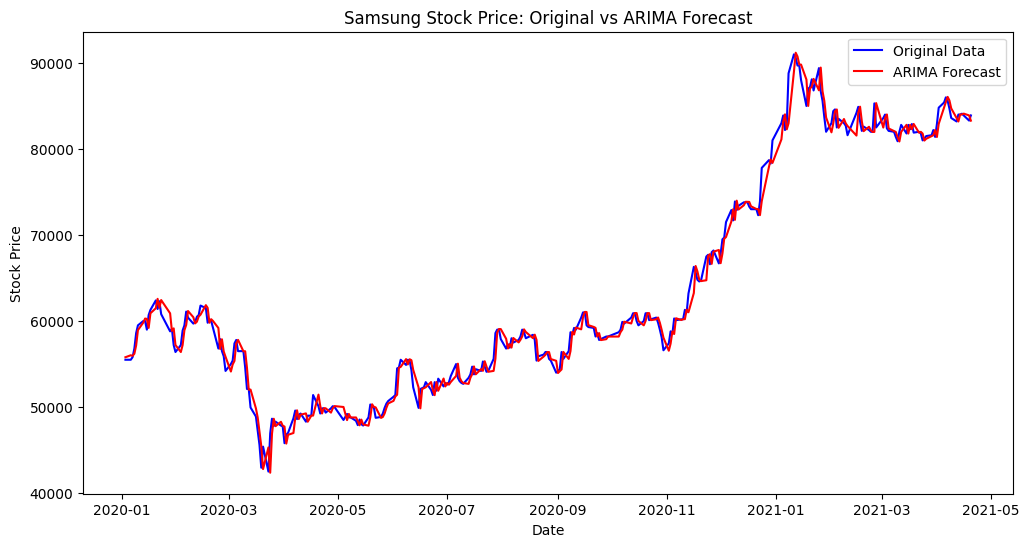

In [57]:
# 모델을 사용해 예측 수행 (start, end 인덱스를 지정하여 예측 범위 설정)
forecast_values = result_111.predict(start=1, end=len(samsung_df['price']) - 1)

# 원본 데이터와 예측값을 함께 그리기
plt.figure(figsize=(12, 6))
plt.plot(samsung_df['price'].index[1:], samsung_df['price'][1:], label='Original Data', color='blue')
plt.plot(samsung_df['price'].index[1:], forecast_values, label='ARIMA Forecast', color='red')
plt.title('Samsung Stock Price: Original vs ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### 5. Box-Jenkins - RMSE

In [116]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# RMSE (Root Mean Squared Error) 계산
arima_rmse = sqrt(mean_squared_error(samsung_df['price'][1:], forecast_values))
arima_rmse

1221.084555615857

---

## [2] Prophet 방법론

In [75]:
df_pr = samsung_df.copy()
df_pr = samsung_df.reset_index()

In [76]:
df_pr.columns = ['ds','y'] # Prophet은 기본적으로 x축 변수를 ds, y축 변수를 y로 설정해줘야함

In [78]:
train_data_pr = df_pr.iloc[:len(samsung_df)-12]
test_data_pr = df_pr.iloc[len(samsung_df)-12:]

In [79]:
from prophet import Prophet

In [121]:
m = Prophet()
m.fit(train_data_pr)
# 예측할 날짜 범위 설정 (원본 데이터와 동일한 기간)
forecast_periods = len(samsung_df)
future = m.make_future_dataframe(periods=forecast_periods, freq='D')

03:36:55 - cmdstanpy - INFO - Chain [1] start processing
03:36:55 - cmdstanpy - INFO - Chain [1] done processing


In [122]:
# 예측 수행
prophet_pred = m.predict(future)

In [123]:
# 예측 결과에서 원본 데이터 기간만 선택
prophet_pred_subset = prophet_pred[(prophet_pred['ds'] >= min(samsung_df.index)) & (prophet_pred['ds'] <= max(samsung_df.index))]
prophet_pred_subset

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,59845.240000,57474.349137,64043.550330,59845.240000,59845.240000,997.192560,997.192560,997.192560,997.192560,997.192560,997.192560,0.0,0.0,0.0,60842.432560
1,2020-01-03,59752.160969,57552.993039,63838.721732,59752.160969,59752.160969,989.147847,989.147847,989.147847,989.147847,989.147847,989.147847,0.0,0.0,0.0,60741.308817
2,2020-01-06,59472.923877,57265.244616,63589.147580,59472.923877,59472.923877,872.964929,872.964929,872.964929,872.964929,872.964929,872.964929,0.0,0.0,0.0,60345.888806
3,2020-01-07,59379.844846,57510.627269,63605.385518,59379.844846,59379.844846,1150.058538,1150.058538,1150.058538,1150.058538,1150.058538,1150.058538,0.0,0.0,0.0,60529.903385
4,2020-01-08,59286.765816,57307.906501,63573.300376,59286.765816,59286.765816,1144.595238,1144.595238,1144.595238,1144.595238,1144.595238,1144.595238,0.0,0.0,0.0,60431.361054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,2021-04-16,82928.597700,80788.626380,87054.178515,82558.579388,83250.892112,989.147847,989.147847,989.147847,989.147847,989.147847,989.147847,0.0,0.0,0.0,83917.745548
324,2021-04-17,82947.352956,77517.272517,83576.897654,82532.638830,83297.391582,-2576.978364,-2576.978364,-2576.978364,-2576.978364,-2576.978364,-2576.978364,0.0,0.0,0.0,80370.374592
325,2021-04-18,82966.108211,77229.466255,83626.598879,82498.362210,83357.625294,-2576.980749,-2576.980749,-2576.980749,-2576.980749,-2576.980749,-2576.980749,0.0,0.0,0.0,80389.127462
326,2021-04-19,82984.863466,80623.203710,87240.601683,82456.025074,83437.681723,872.964929,872.964929,872.964929,872.964929,872.964929,872.964929,0.0,0.0,0.0,83857.828395


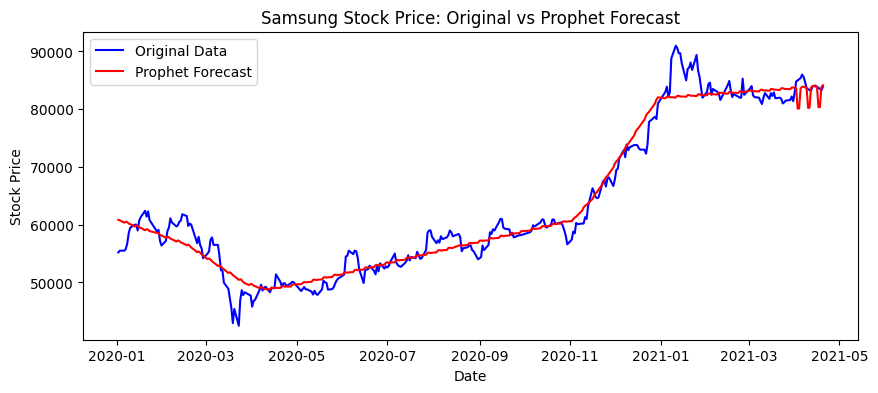

In [125]:
# 시각화
plt.figure(figsize=(10, 4))
plt.plot(samsung_df.index, samsung_df['price'], label='Original Data', color='blue')
plt.plot(prophet_pred_subset['ds'], prophet_pred_subset['yhat'], label='Prophet Forecast', color='red')
plt.title('Samsung Stock Price: Original vs Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [127]:
from datetime import datetime

# prophet_pred의 날짜 범위를 samsung_df와 동일하게 조정
prophet_pred_subset = prophet_pred[(prophet_pred['ds'] >= min(samsung_df.index)) & (prophet_pred['ds'] <= max(samsung_df.index))]

# 공통 날짜에 대해서만 데이터 추출
common_dates = prophet_pred_subset['ds'].isin(samsung_df.index)
samsung_prices = samsung_df.loc[prophet_pred_subset[common_dates]['ds'], 'price']

# RMSE 계산
prophet_rmse = sqrt(mean_squared_error(samsung_prices, prophet_pred_subset[common_dates]['yhat']))
prophet_rmse

2436.3618214389644

## [3] 원본데이터 & ARIMA & Prophet 비교

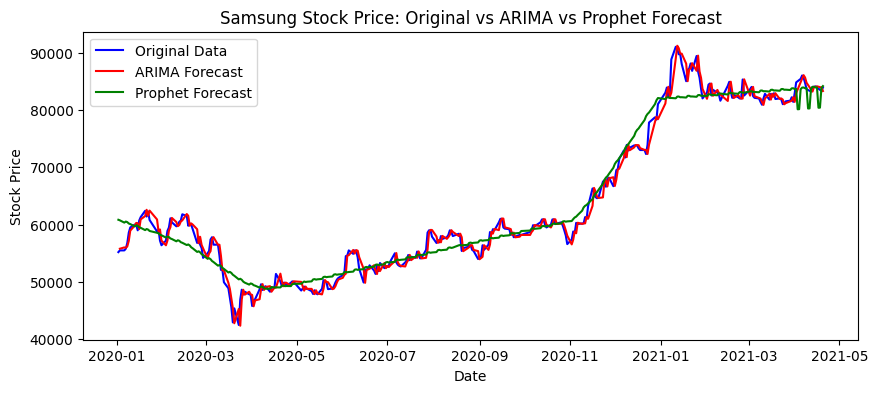

In [126]:
# 원본 데이터와 ARIMA, Prophet의 예측값 비교 시각화
plt.figure(figsize=(10, 4))
plt.plot(samsung_df.index, samsung_df['price'], label='Original Data', color='blue')
plt.plot(forecast_values.index, forecast_values, label='ARIMA Forecast', color='red')
plt.plot(prophet_pred_subset['ds'], prophet_pred_subset['yhat'], label='Prophet Forecast', color='green')
plt.title('Samsung Stock Price: Original vs ARIMA vs Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [130]:
print('prophet_rmse:',prophet_rmse)
print('arima_rmse:',arima_rmse)

prophet_rmse: 2436.3618214389644
arima_rmse: 1221.084555615857


분석 결과를 보면, ARIMA 모델의 RMSE 값이 Prophet 모델보다 작은 것을 확인할 수 있습니다.<br>
RMSE는 예측 모델의 성능을 평가하는 지표로, 작을수록 예측이 원본 데이터에 더 가깝게 일치한다는 의미입니다.<br>
따라서 현재의 결과에 따르면 ARIMA 모델이 Prophet 모델보다 더 좋은 성능을 보이고 있는 것으로 판단됩니다.